BI pr 2

RNA-Seq Data Analysis. Task: Analyze a provided RNA-Seq dataset and perform 
differential gene expression analysis. 

In [1]:
# -----------------------------
# RNA-Seq Differential Expression in Python
# ----------------------------

import pandas as pd
import numpy as np
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# -----------------------------
# 1. Load dataset
# -----------------------------
# Dummy counts matrix (10 genes × 6 samples)

data = {
    "Control1": [120,150,10,500,200,5,80,300,50,400],
    "Control2": [130,145,12,480,210,6,85,310,55,420],
    "Control3": [125,160,11,490,205,7,90,320,60,410],
    "Treated1": [300,400,15,450,220,8,150,100,55,420],
    "Treated2": [310,420,18,460,230,9,160,90,60,430],
    "Treated3": [320,390,20,470,225,10,155,95,65,440],
}

genes = ["GeneA","GeneB","GeneC","GeneD","GeneE","GeneF","GeneG","GeneH","GeneI","GeneJ"]

counts = pd.DataFrame(data, index=genes)

# Sample groups
control_samples = ["Control1","Control2","Control3"]
treated_samples = ["Treated1","Treated2","Treated3"]


In [3]:
# -----------------------------
# 2. Calculate log2 Fold Change
# -----------------------------
mean_control = counts[control_samples].mean(axis=1)
mean_treated = counts[treated_samples].mean(axis=1)

log2FC = np.log2((mean_treated + 1) / (mean_control + 1))  # +1 to avoid division by zero


In [4]:
# -----------------------------
# 3. T-test for significance
# -----------------------------
p_values = []
for gene in counts.index:
    stat, p = ttest_ind(counts.loc[gene, treated_samples], counts.loc[gene, control_samples])
    p_values.append(p)

# Adjust p-values (Benjamini-Hochberg FDR)
p_values = np.array(p_values)
sorted_idx = np.argsort(p_values)
rank = np.arange(1, len(p_values)+1)
adj_p = p_values[sorted_idx] * len(p_values) / rank
adj_p[adj_p > 1] = 1

adj_p_values = np.empty_like(adj_p)
adj_p_values[sorted_idx] = adj_p


In [5]:
# -----------------------------
# 4. Compile results
# -----------------------------
results = pd.DataFrame({
    "Gene": counts.index,
    "log2FC": log2FC,
    "p_value": p_values,
    "adj_p_value": adj_p_values
}).set_index("Gene")

print(results)

# Save results
results.to_csv("DEG_results_python.csv")


         log2FC   p_value  adj_p_value
Gene                                  
GeneA  1.303491  0.000009     0.000044
GeneB  1.405160  0.000014     0.000047
GeneC  0.637430  0.013012     0.021687
GeneD -0.090956  0.021312     0.030445
GeneE  0.133678  0.008050     0.016100
GeneF  0.514573  0.021312     0.026640
GeneG  0.859137  0.000068     0.000170
GeneH -1.695808  0.000005     0.000048
GeneI  0.123382  0.287864     0.287864
GeneJ  0.068549  0.070484     0.078316


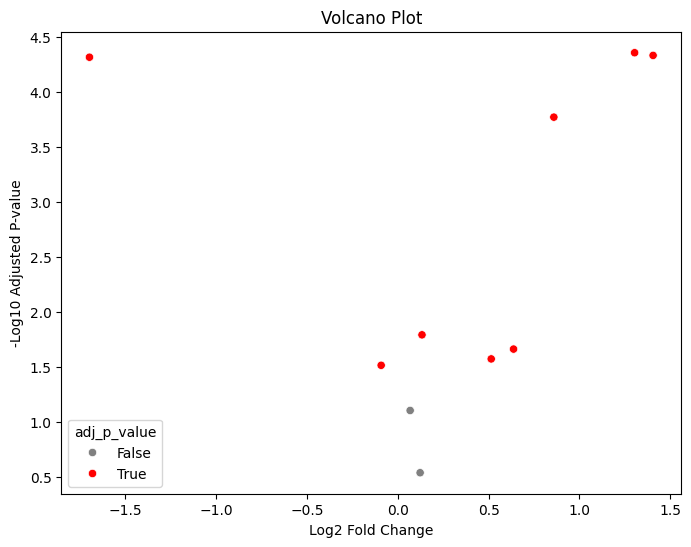

In [6]:
# -----------------------------
# 5. Volcano Plot
# -----------------------------
plt.figure(figsize=(8,6))
sns.scatterplot(
    x="log2FC",
    y=-np.log10(results["adj_p_value"]),
    data=results,
    hue=results["adj_p_value"] < 0.05,
    palette={True: 'red', False: 'gray'}
)
plt.title("Volcano Plot")
plt.xlabel("Log2 Fold Change")
plt.ylabel("-Log10 Adjusted P-value")
plt.show()


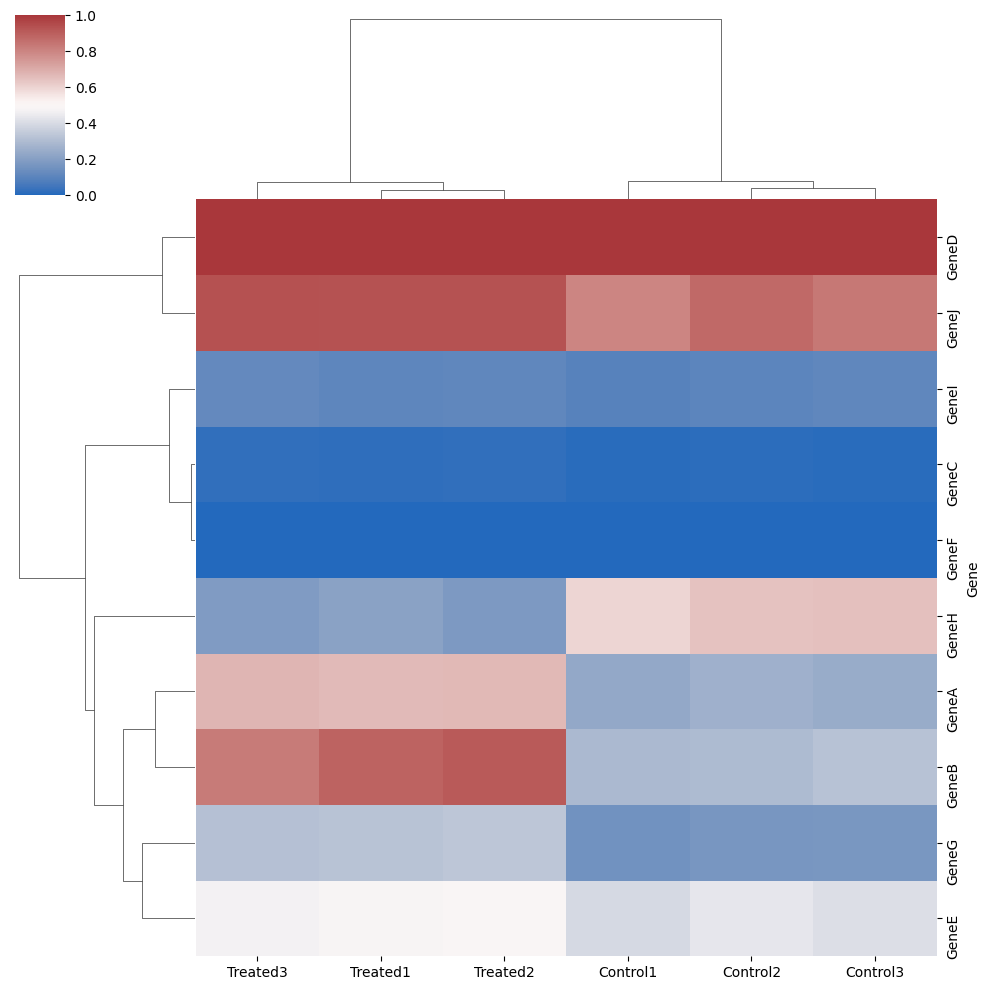

In [7]:
# -----------------------------
# 6. Heatmap (top 10 genes)
# -----------------------------
top_genes = results.sort_values("adj_p_value").head(10).index
sns.clustermap(counts.loc[top_genes], cmap="vlag", standard_scale=1)
plt.show()
